# Encoder Only

https://github.com/neelnanda-io/TransformerLens/blob/main/demos/BERT.ipynb

In [1]:
import torch, transformer_lens
from measureLM import visualizing, decoding, patching, scoring

from transformers import AutoTokenizer
from transformer_lens import HookedEncoder

In [2]:
model = HookedEncoder.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model.cfg.spacing = ""
model.tokenizer = tokenizer

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model bert-base-cased into HookedTransformer


### 1) Get activations


prompt 0
layer 0: [(0.0007, 'France'), (0.0002, 'Paris'), (0.0004, 'Poland'), (0.0, 'Warsaw'), (0.0002, 'London'), (0.0003, 'Berlin')]
layer 1: [(0.0008, 'France'), (0.0002, 'Paris'), (0.0008, 'Poland'), (0.0001, 'Warsaw'), (0.0003, 'London'), (0.0008, 'Berlin')]
layer 2: [(0.0006, 'France'), (0.0003, 'Paris'), (0.0004, 'Poland'), (0.0001, 'Warsaw'), (0.0003, 'London'), (0.0014, 'Berlin')]
layer 3: [(0.0005, 'France'), (0.0006, 'Paris'), (0.0002, 'Poland'), (0.0001, 'Warsaw'), (0.0006, 'London'), (0.0009, 'Berlin')]
layer 4: [(0.0006, 'France'), (0.0012, 'Paris'), (0.0001, 'Poland'), (0.0001, 'Warsaw'), (0.0006, 'London'), (0.0004, 'Berlin')]
layer 5: [(0.0004, 'France'), (0.0009, 'Paris'), (0.0001, 'Poland'), (0.0001, 'Warsaw'), (0.0003, 'London'), (0.0004, 'Berlin')]
layer 6: [(0.0003, 'France'), (0.0011, 'Paris'), (0.0002, 'Poland'), (0.0002, 'Warsaw'), (0.0006, 'London'), (0.0005, 'Berlin')]


/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:39: UserWarning: torch.sort is supported by MPS on MacOS 13+, please upgrade. Falling back to CPU (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Sort.mm:30.)
  token_ranks = torch.argsort(scores, descending=True)
/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:42: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  token_rank = torch.where(token_ranks == token_id)[0].item()


layer 7: [(0.0004, 'France'), (0.0021, 'Paris'), (0.0002, 'Poland'), (0.0003, 'Warsaw'), (0.0007, 'London'), (0.0007, 'Berlin')]
layer 8: [(0.0003, 'France'), (0.0034, 'Paris'), (0.0002, 'Poland'), (0.0004, 'Warsaw'), (0.0015, 'London'), (0.0011, 'Berlin')]
layer 9: [(0.0021, 'France'), (0.0192, 'Paris'), (0.0006, 'Poland'), (0.0017, 'Warsaw'), (0.0091, 'London'), (0.007, 'Berlin')]
layer 10: [(0.0625, 'France'), (0.0455, 'Paris'), (0.0169, 'Poland'), (0.0179, 'Warsaw'), (0.0345, 'London'), (0.0385, 'Berlin')]
layer 11: [(0.02, 'France'), (0.0385, 'Paris'), (0.25, 'Poland'), (0.5, 'Warsaw'), (0.0476, 'London'), (0.05, 'Berlin')]


/Users/niklasstoehr/Code/measureLM/measureLM/visualizing.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


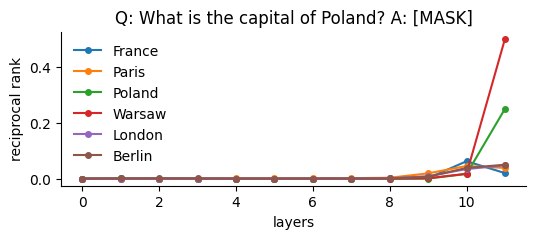

In [3]:
prompts = ['Q: What is the capital of Poland? A: [MASK]']
logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

token_candidates = ["France", "Paris", "Poland", "Warsaw", "London", "Berlin"]
tok_idx = scoring.token_select(tokens, model, select_token="[MASK]")
scored_tokens = scoring.scores_to_tokens(layer_scores[tok_idx], model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

In [4]:
from measureLM import visualizing, decoding
import torch, transformer_lens


def token_select(tokens, model, select_token="[MASK]"):  # "Ġhi"
    if select_token is not None:
        select_token_id = model.tokenizer.convert_tokens_to_ids(select_token)  ## retrieve index of [MASK]
        batch_idx, seq_idx = (tokens == select_token_id).nonzero(as_tuple=True)

    if select_token is None or select_token not in model.tokenizer.vocab:  ## get last token before padding
        batch_idx, seq_idx = (tokens != model.tokenizer.pad_token_id).nonzero(as_tuple=True)
        batch_idx, unique_batch_counts = torch.unique_consecutive(batch_idx, return_counts=True)
        unique_batch_cumsum = torch.cumsum(unique_batch_counts, dim=0) - 1
        seq_idx = seq_idx[unique_batch_cumsum]

    assert batch_idx.shape[0] > 0, f"mlm-type model and {select_token} token not in prompt text"
    batch_seq_idx = list(zip(batch_idx, seq_idx))
    return batch_seq_idx


def topK_scores(scores, model, topk=5):
    pred_scores, pred_tokens = [], []
    topK_preds = torch.topk(scores, k=topk)

    scores = topK_preds.values.tolist()
    indices = topK_preds.indices.tolist()
    # for scores, indices in zip(topK_preds.values.tolist(), topK_preds.indices.tolist()):
    scores = list(map(lambda score: round(score, 2), scores))
    pred_scores.append(scores)
    tokens = list(map(lambda idx: model.tokenizer.convert_ids_to_tokens(idx), indices))
    pred_tokens.append(tokens)
    return pred_tokens, pred_scores


def get_token_rank(scores, model, token):
    assert "spacing" in dir(model.cfg), "need to set e.g. model.cfg.spacing = Ġ"
    token = model.cfg.spacing + token
    token_id = model.tokenizer.convert_tokens_to_ids(token)
    token_ranks = torch.argsort(scores, descending=True)

    token_scores = scores[token_ranks]
    token_rank = torch.where(token_ranks == token_id)[0].item()
    token_score = token_scores[token_rank]
    token_rank = round(1 / (token_rank + 1), 4)  # round(1-(token_rank / len(scores)), 4)
    return token_rank, token_score


def scores_to_tokens(prompt_layer_scores, prompt_tok_idx, model, mode=2, print_res=True):
    prompt_layer_res = {}
    for i, tok_idx in enumerate(prompt_tok_idx):
        print(f"\nprompt {tok_idx[0]}")
        print(tok_idx)
        layer_scores = prompt_layer_scores[tok_idx]
        layer_res = {}
        print(layer_scores.shape)
        for l, scores in enumerate(layer_scores):
            if isinstance(mode, int):  ## get top tokens
                tokens, scores = topK_scores(scores, model, topk=mode)
                layer_res[l] = list(zip(scores, tokens))
                if print_res:
                    print(f"layer {l}: {layer_res[l]}")

            elif isinstance(mode, list):  ## search specific tokens
                if isinstance(mode[0], list) and len(mode) == len(layer_scores):
                    pass  ## per prompt mode
                elif isinstance(mode[0], str):
                    token_ranks, token_scores = [], []
                    for token in mode:
                        token_rank, token_score = get_token_rank(scores, model, token)
                        token_ranks.append(token_rank)
                    layer_res[l] = token_ranks
                    if print_res:
                        print(f"layer {l}: {list(zip(layer_res[l], mode))}")
        prompt_layer_res[i] = layer_res
    return prompt_layer_res


['.', '"', 'the']
patching blocks.0.hook_mlp_out
extracting blocks.0.hook_resid_post
patching blocks.1.hook_mlp_out
extracting blocks.1.hook_resid_post
patching blocks.2.hook_mlp_out
extracting blocks.2.hook_resid_post
patching blocks.3.hook_mlp_out
extracting blocks.3.hook_resid_post
patching blocks.4.hook_mlp_out
extracting blocks.4.hook_resid_post
patching blocks.5.hook_mlp_out
extracting blocks.5.hook_resid_post
patching blocks.6.hook_mlp_out
extracting blocks.6.hook_resid_post
patching blocks.7.hook_mlp_out
extracting blocks.7.hook_resid_post
patching blocks.8.hook_mlp_out
extracting blocks.8.hook_resid_post
patching blocks.9.hook_mlp_out
extracting blocks.9.hook_resid_post
patching blocks.10.hook_mlp_out
extracting blocks.10.hook_resid_post
patching blocks.11.hook_mlp_out
extracting blocks.11.hook_resid_post

prompt 0
(tensor(0), tensor(1))
torch.Size([12, 28996])
layer 0: [(1.0, 'Germany'), (0.25, 'Berlin'), (0.0001, 'mug'), (0.0094, 'Paris'), (0.0001, 'table')]
layer 1: [(1.0, 

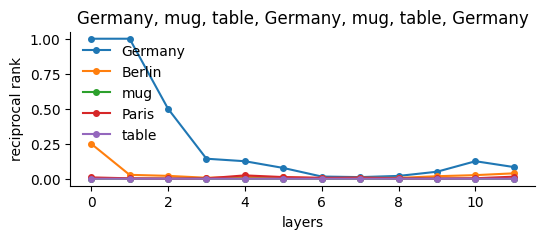

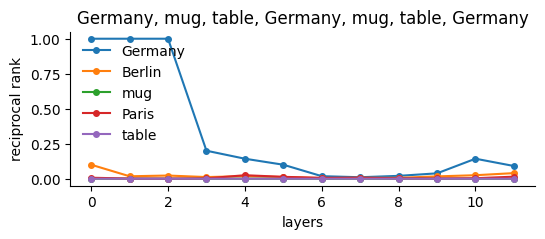

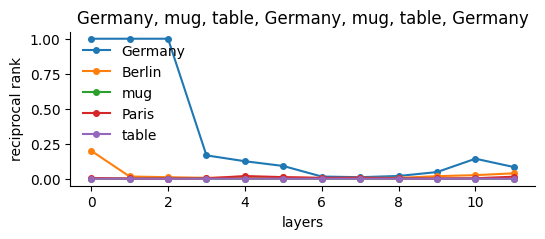

In [7]:
new_prompts = ["Germany, mug, table, Germany, mug, table, Germany"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
insert_tok_idx = scoring.token_select(new_tokens, model, select_token="Germany")
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[insert_tok_idx], k=3).indices.tolist()[0])
print(pred)

patch_logits, resid_post = patching.intervene(new_tokens, activs, model, extract_tok_idx=tok_idx, insert_tok_idx=insert_tok_idx, l_start_end=[0, 15])
resid_layer_scores = decoding.early_decoding(resid_post, model)

new_token_candidates = ["Germany", "Berlin", "mug", "Paris", "table"]

## scoring
extract_tok_idx = token_select(new_tokens, model, select_token="Germany")
scored_tokens = scores_to_tokens(resid_layer_scores, extract_tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
